In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# leer las trayectorias generadas
import h5py

data_file = "trayectorias.h5"

with h5py.File(data_file, "r") as hf:
    trayectorias = hf["trayectorias"][:]

# Asegúrate de que las trayectorias se ajusten a tus necesidades específicas
# Si es necesario, puedes transformar los datos en tensores TensorFlow
trayectorias = tf.constant(trayectorias, dtype=tf.float32)


In [3]:
# n_particula, (posicion,velocidad), tiempo
trayectorias.shape
#TensorShape([300,2,300])

TensorShape([300, 2, 300])

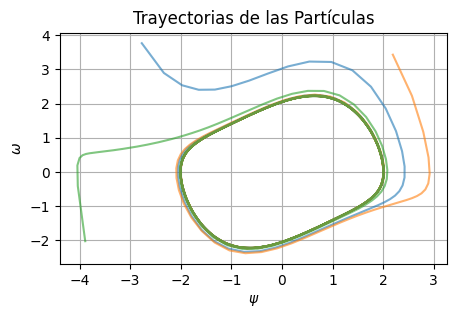

In [4]:
def plot_trayectoria(trayectorias, N):
    plt.figure(figsize=(5, 3))
    if len(trayectorias.shape) == 2:
        print('one data point')
        plt.plot(trayectorias[0], trayectorias[1], alpha=0.6)

    else:
        for i in range(N):
            plt.plot(trayectorias[i][0], trayectorias[i][1], alpha=0.6)
    plt.xlabel(r'$\psi$')
    plt.ylabel(r'$\omega$')
    plt.title('Trayectorias de las Partículas')
    plt.grid()
    plt.show()

plot_trayectoria(trayectorias, 3)

# ordenamiento de los datos

In [14]:

# shape: TensorShape([300, 2, 300])
dataset = tf.data.Dataset.from_tensor_slices(trayectorias)

# Determina los tamaños de tus conjuntos de datos
size = tf.data.experimental.cardinality(dataset).numpy()
print("Total de datos: ", size)
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = int(0.15 * size)

# Mezcla tus datos
dataset = dataset.shuffle(size)

# Divide tus datos en conjuntos de entrenamiento, validación y prueba
train_data = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size)

print('\ttraining size: ', len(train_data))
print('\tvalidation size: ', len(val_data))
print('\ttesting size: ', len(test_data))

# Para obtener el primer elemento
first_data = next(iter(dataset.take(1)))
second_data = next(iter(dataset.skip(1).take(1)))

print("Forma de un solo dato: ", first_data.shape)

Total de datos:  300
	training size:  210
	validation size:  45
	testing size:  45
Forma de un solo dato:  (2, 300)


one data point


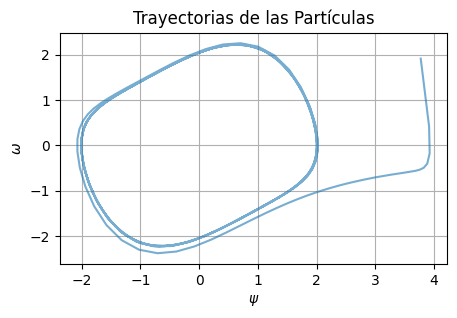

In [6]:
plot_trayectoria(first_data, 0)

# El modelo

In [8]:
import tensorflow as tf


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.tanh, input_shape=(1,)),  # Input layer (time)
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(1) # output position
])

def initial_value_loss(y_true, y_pred):
    # Condición de borde
    return tf.square(y_true[0] - y_pred[0])

def point_loss(y_true, y_pred):
    # Loss function for every point
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile the model
model.compile(optimizer='adam', loss=[initial_value_loss, point_loss])

In [21]:
x_pred = next(iter(train_data.take(1)))[0,:]
v_pred = next(iter(train_data.take(1)))[1,:]

In [9]:


# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=100)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 2, 300)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 2, 300), dtype=float32)
      • training=True
      • mask=None


# un optimizador

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras_tuner import RandomSearch

# Supongamos que tus datos están en el tensor 'trayectorias'
trayectorias

# Separa tus datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(trayectorias, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

def build_model(hp):
    # aqui va la construccion del modelo
    model = tf.keras.models.Sequential()
    
    # Añade tus capas aquí. Por ejemplo:
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # una sola salida para predecir la posición

    # Ajusta los hiperparámetros del optimizador Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
    hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2),
                loss=tf.keras.losses.MeanSquaredError(),  # usa MSE para la regresión
                metrics=['mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='mse',  # minimiza el error cuadrático medio
    max_trials=5,
    executions_per_trial=3)

tuner.search(train_data, epochs=60, validation_data=val_data)

# Obtén los hiperparámetros óptimos
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"La tasa de aprendizaje óptima para el optimizador es {best_hps.get('learning_rate')}.")
print(f"El beta_1 óptimo para el optimizador es {best_hps.get('beta_1')}.")
print(f"El beta_2 óptimo para el optimizador es {best_hps.get('beta_2')}.")
